In [2]:
import json

#FOLDER = "C:\\Users\\be34gof\\Downloads\\TSU-141-E"
FOLDER = "C:\\Users\\be34gof\\Downloads\\25_11_2021"
MIN_PEAK_HEIGHT = 0.05  # minimum peak height relative to the largest peak
PEAK_BOARDER_RELATIVE_HEIGHT = 0.01  # peak height relative to the peak maximum which sets the integration limits
MAX_PEAK_WIDTH = 1  # maximum peak with, to limit very small and broad peaks
MIN_PEAK_DISTANCE = 0.1  # minimum peak distance, clsoer peaks are counted as one

ALLOW_PPM_STRETCH = False  # weather the ppm scale can be stretched to get expected peaks

FIXED_SCALE = [0, 6]
EXPECTED_PEAKS = [2.7, 3.9, 4.5]  # list of expected peaks for shift correction
MANUAL_PEAKS = [2.7, 3.9, 4.12, 4.3, 4.5]  # list of expected peaks for shift correction
MANUAL_PEAK_RANGES = [
    [2.40, 3.3],
    [3.4, 4.0],
    [4.0, 4.15],
    [4.15, 4.36],
    [4.37, 4.78],
]

SPECIES_PEAKS = [[3.9], [4.12], [4.3], [4.5],[2.7]]
SPECIES_PEAK_AREAS = [[2], [4], [6], [6],[6]]
SPECIES_PEAKS_NAMES = ["OME-1","OME-2","OME-3+","Trioxane","OME-CH3"]

# REFERENCE_PEAK=None
REFERENCE_PEAK = 2.7  # reference peak used as integration standart
REFERENCE_PEAK_AREA = 6  # area of the reference peak
REFERENCE_PEAK_WINDOW = 0.4  # maximum derivation from the reference peak

PLOT_INTERMEDIATES = False  # plot all intermediate steps
PLOT_RESULT = True  # plot result
SHOW_PLOTS = False  # live show plots, normally False

CREATE_TABLE = True  # results are stored as table files
RESULT_TABLE = True  # merge all results to on table
RECREATE = False  # recalc spec even if it is already in the results table
TABLE_TYPE = "xlsx"  # type of table data, use 'xlsx' for an excel-file or 'csv' for a csv-file



## dont do stuff here

import logging
import sys, os

import dateutil
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

if __name__ == '__main__':
    ddir = os.path.dirname(os.path.abspath(""))
    while "autochem" not in os.listdir(ddir):
        ddir = os.path.dirname(ddir)
    sys.path.insert(0, ddir)
    sys.path.append(ddir)

    logging.basicConfig()


from autochem.spectra.nmr.reader import read_nmr, NMRReadError
from autochem.utils.corrections import norm_data, shift_data, scale_data
from autochem.utils.signals.peak_detection import find_peaks, get_reference_peak, PeakNotFoundError, peak_integration, \
    merge_peaks_data, cut_peaks_data, factorize_peak_data, manual_peak_finder
from autochem.spectra.nmr.utils import zoom
from autochem.utils.corrections.shift import get_signal_shift

logger = logging.getLogger("autochem")
logger.setLevel("DEBUG")
MANUAL_PEAKS  = np.array(MANUAL_PEAKS)
EXPECTED_PEAKS = np.array(EXPECTED_PEAKS)
assert REFERENCE_PEAK in EXPECTED_PEAKS
assert len(MANUAL_PEAK_RANGES) == len(MANUAL_PEAKS)
assert len(SPECIES_PEAKS_NAMES) == len(SPECIES_PEAKS)

SPECIES_PEAKS = np.array(SPECIES_PEAKS)
SPECIES_PEAK_AREAS = np.array(SPECIES_PEAK_AREAS)
assert SPECIES_PEAK_AREAS.shape == SPECIES_PEAKS.shape


In [4]:
results_df = pd.DataFrame()
if RESULT_TABLE:
    res_file = os.path.join(FOLDER, "results.xlsx")
    try:
        results_df = pd.read_excel(res_file, index_col=[0, 1, 2, 3])
    except FileNotFoundError:
        pass
change = False

In [6]:
results_df.sort_values("startTime",inplace=True)

In [7]:
times = pd.to_datetime(results_df.index.get_level_values('startTime').unique()).values
apd = np.zeros((len(times),SPECIES_PEAKS.size))*np.nan
for i,t in enumerate(times):
    #_apd = []
    d = results_df.loc[results_df.index.get_level_values('startTime') == t]

    dist_matrix = np.abs( np.subtract.outer(SPECIES_PEAKS.flatten(),d["ppm"].values))

    while not np.isnan(dist_matrix).all():
        minidx = np.unravel_index(np.nanargmin(dist_matrix), dist_matrix.shape)
        apd[i,minidx[0]]=d["area"].values[minidx[1]]
        dist_matrix[minidx[0],:]=np.nan
        dist_matrix[:,minidx[1]]=np.nan


tdiffa = times
tdiffa = tdiffa - tdiffa.min()
tdiffa = tdiffa / np.timedelta64(1, 's')

In [8]:
csa=apd/SPECIES_PEAK_AREAS.flatten()

C:\Users\be34gof\AppData\Local\Temp/ipykernel_21676/2025706884.py:26: RuntimeWarning: invalid value encountered in true_divide
  diff_mvg_avg_diff_mvg_avg = np.abs(mvg_avg_diff_mvg_avg-mvg_avg_diff)/mvg_avg_diff_mvg_avg


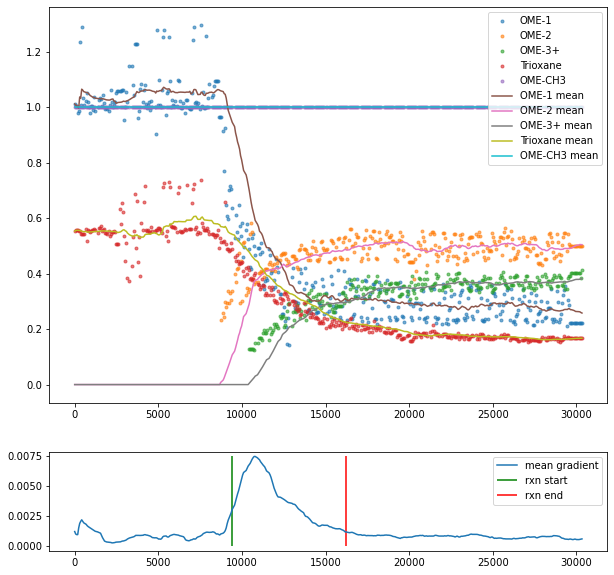

In [100]:
def ffill(arr):
        arr=arr.copy()
        mask = np.isnan(arr)
        idx = np.where(~mask, np.arange(mask.shape[0]), 0)
        np.maximum.accumulate(idx, axis=0, out=idx)
        arr = arr[idx]
        return arr
    
def moving_average(a, n=3) :
        n=min(n,a.shape[0])
        a=a.copy()
        ret = np.cumsum(np.nan_to_num(a), dtype=float,axis=0)
        ret[n:] = ret[n:] - ret[:-n]
        ret[n - 1:]/=n
        if n>1:
            ret[:n - 1]=(ret[:n - 1].T/np.arange(1,n)).T
        return ret
    
cs=csa[:]
tdiff=tdiffa[:]
mvg_avg = moving_average(cs,30)

mvg_avg_diff = np.abs(cs-mvg_avg)
mvg_avg_diff_mvg_avg = moving_average(mvg_avg_diff,10)
th=1
diff_mvg_avg_diff_mvg_avg = np.abs(mvg_avg_diff_mvg_avg-mvg_avg_diff)/mvg_avg_diff_mvg_avg

outlier=diff_mvg_avg_diff_mvg_avg>th

n_cs=cs.copy()
n_cs[outlier]=np.nan

if n_cs.ndim>1:
    for i in range(n_cs.shape[1]):
        n_cs[:,i]=ffill(n_cs[:,i])
else:
    n_cs=ffill(n_cs)

n_mvg_avg = moving_average(n_cs,30)

ep_th=0.003
lp_th=0.0012
grad = np.abs(np.gradient(n_mvg_avg,axis=0))
avg_grad = moving_average(grad,20)

entry_point = avg_grad.mean(1)


ep_idx=(entry_point>ep_th).argmax()

lp_idx=(entry_point[ep_idx:]>lp_th).argmin()+ep_idx
        
f, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4,1]},figsize=(10,10))
for i in range(n_cs.shape[1]):
    ax1.plot(tdiff,n_cs[:,i],".",label=SPECIES_PEAKS_NAMES[i],alpha=0.6)
for i in range(n_cs.shape[1]):
    ax1.plot(tdiff,n_mvg_avg[:,i],label=SPECIES_PEAKS_NAMES[i]+" mean")

ax2.plot(tdiff,entry_point,label="mean gradient")

ep_idx=(entry_point>ep_th).argmax()
lp_idx=(entry_point[ep_idx:]>lp_th).argmin()+ep_idx
if ep_idx>0:
    ax2.vlines(tdiff[ep_idx],0,entry_point.max(),color="green",label="rxn start")
    if lp_idx>ep_idx:
        ax2.vlines(tdiff[lp_idx],0,entry_point.max(),color="red",label="rxn end")

        
ax1.legend(loc='upper right')
ax2.legend()
    

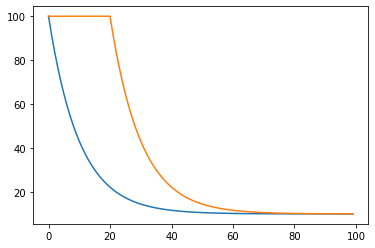

In [91]:
def dec(x,n0,nn,lamb):
    return (n0-nn)*np.exp(-lamb*x)+nn
x=np.arange(100)
plt.plot(x,dec(x,100,10,0.1))

def lin_dec(x,n0,nn,lamb,k):
    i=(x>=k).argmax()
    return np.concatenate([
        [n0]*i,
        dec(x[i:]-k,n0,nn,lamb)
    ])
plt.plot(x,lin_dec(x,100,10,0.1,20))

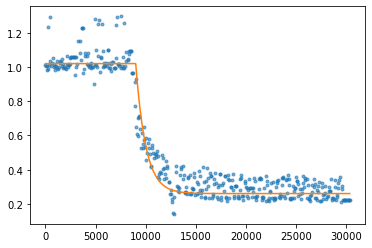

In [92]:
plt.plot(tdiff,n_cs[:,0],".",label=SPECIES_PEAKS_NAMES[0],alpha=0.6)
ta=9000
te=25000
tia=(tdiff>=ta).argmax()
tie=(tdiff>=te).argmax()

plt.plot(tdiff,lin_dec(tdiff,np.median(n_cs[:tia,0]),np.median(n_cs[tie:,0]),0.001,ta))


In [95]:
e=np.median(n_cs[tie:,0])
def find_start(x,ta,lam):
    tia=(x>=ta).argmax()
    return lin_dec(tdiff,np.median(n_cs[:tia,0]),e,lam,ta)

(tf,lf),_ = curve_fit(find_start,tdiff,n_cs[:,0],[9000,0.001])

In [96]:
tf,lf

(8430.022813517977, 0.0005798139954935491)

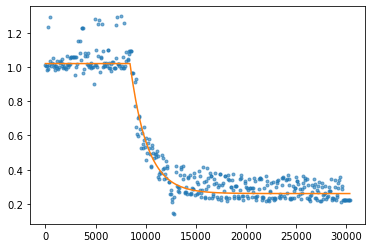

In [98]:
plt.plot(tdiff,n_cs[:,0],".",label=SPECIES_PEAKS_NAMES[0],alpha=0.6)
plt.plot(tdiff,lin_dec(tdiff,np.median(n_cs[:(tdiff>=tf).argmax(),0]),e,lf,tf))

In [179]:
from autochem.kinetics.simulate import simulate_reaction_set
t_map=tdiff>tf
ts=tdiff[t_map]-tf
n_omes=10
names=["TriOx","FA"]+[f"OME{n}" for n in range(1,n_omes+1)]
rm=[
    [[1,0]+[0 for _ in  range(n_omes)],[0,3]+[0 for _ in  range(n_omes)]], #Triox->3 FA
]
for j in range(n_omes-1): # -1 since last ome has no product
    rm.append(
        [[0,1]+[1 if i==j else 0 for i in  range(n_omes)],[0,0]+[1 if i==j+1 else 0 for i in  range(n_omes)]]
    )


ic=[n_cs[~t_map,3].mean(),0,n_cs[~t_map,0].mean()]+[0 for _ in  range(n_omes-1)]
rm=np.array(rm)
ic=np.array(ic)

k_tr_fh=0.001
k_fh_tr=0.001
k_ome_add=0.1
k_ome_sub=0.001
k_ome1_ome2,k_ome2_ome1=k_ome_add,k_ome_sub

a=np.zeros_like(np.nan_to_num(n_cs[t_map,0:3+1]))
reacts=(0,1,3)
def f(ts,k_tr_fh,k_fh_tr,k_ome1_ome2,k_ome2_ome1,k_ome_add,k_ome_sub):
    print(k_tr_fh,k_fh_tr,k_ome1_ome2,k_ome2_ome1,k_ome_add,k_ome_sub)
    rc=[
        [k_tr_fh,k_fh_tr],
        [k_ome1_ome2,k_ome2_ome1],
    ]+[[k_ome_add,k_ome_sub] for  _ in  range(n_omes-2)]
    rc=np.array(rc)


    r=simulate_reaction_set(rm, rc, ic, ts)
    
    _a=a.copy()
    _a[:,0]=r["y"][2]
    _a[:,1]=r["y"][3]
    _a[:,2]=r["y"][3:].sum(0)
    _a[:,3]=r["y"][0]
    return _a[:,(reacts)].flatten()
    return r["y"][2]+\
            r["y"][3]+\
            r["y"][3:].sum(0)+\
            r["y"][0]

    triox_fit=r["y"][0]
    ome1_fit=r["y"][2]
    ome2_fit=r["y"][3]
    ome3p_fit=r["y"][4:].sum(0)

    plt.plot(r["t"],ome1_fit,label="OME1 fit")
    #plt.plot(r["t"],ome2_fit,label="OME2 fit")
    #plt.plot(r["t"],ome3p_fit,label="OME3+ fit")
    #plt.plot(r["t"],triox_fit,label="TriOx fit")

    plt.plot(ts,n_cs[t_map,0],".",label="OME1")
    #plt.plot(ts,n_cs[t_map,1],".",label="OME2")
    #plt.plot(ts,n_cs[t_map,2],".",label="OME3")
    #plt.plot(ts,n_cs[t_map,3],".",label="TriOx")

f = curve_fit(f,
              ts,
              np.nan_to_num(n_cs[t_map][:,0:(3+1)])[:,(reacts)].flatten(),
              #ts,n_cs[t_map,0]+\
              #np.nan_to_num(n_cs[t_map,1])+\
              # np.nan_to_num(n_cs[t_map,2])+\
              #n_cs[t_map,3],
              [k_tr_fh,k_fh_tr,k_ome1_ome2,k_ome2_ome1,k_ome_add,k_ome_sub],bounds=([1e-12,1e-12,1e-12,1e-12,1e-12,1e-12],[1,1,1,1,1,1]))

0.001 0.001 0.1 0.001 0.1 0.001


C:\Users\be34gof\Documents\programming\autochem\autochem\kinetics\simulate.py:35: RuntimeWarning: divide by zero encountered in log
  log_y=np.nan_to_num(np.log(y))
C:\Users\be34gof\Documents\programming\autochem\autochem\kinetics\simulate.py:56: RuntimeWarning: overflow encountered in multiply
  v_bwd=ln_rate[1]+(reaction[1]*log_y).sum()
C:\Users\be34gof\Syn\programming\envs\autochem\lib\site-packages\numpy\core\_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\be34gof\Documents\programming\autochem\autochem\kinetics\simulate.py:35: RuntimeWarning: invalid value encountered in log
  log_y=np.nan_to_num(np.log(y))


0.0010000149011611939 0.001 0.1 0.001 0.1 0.001
0.001 0.0010000149011611939 0.1 0.001 0.1 0.001
0.001 0.001 0.1000000149011612 0.001 0.1 0.001
0.001 0.001 0.1 0.0010000149011611939 0.1 0.001
0.001 0.001 0.1 0.001 0.1000000149011612 0.001
0.001 0.001 0.1 0.001 0.1 0.0010000149011611939
0.00043747303157428384 0.33267597336130256 0.05314889696317332 0.0010368676609508831 0.10483330987196715 0.0029278860057152787
0.0004374879327354777 0.33267597336130256 0.05314889696317332 0.0010368676609508831 0.10483330987196715 0.0029278860057152787
0.00043747303157428384 0.33267598826246375 0.05314889696317332 0.0010368676609508831 0.10483330987196715 0.0029278860057152787
0.00043747303157428384 0.33267597336130256 0.053148911864334514 0.0010368676609508831 0.10483330987196715 0.0029278860057152787
0.00043747303157428384 0.33267597336130256 0.05314889696317332 0.001036882562112077 0.10483330987196715 0.0029278860057152787
0.00043747303157428384 0.33267597336130256 0.05314889696317332 0.001036867660950

In [180]:
f[0]

array([3.98107260e-04, 9.87972763e-01, 1.26979229e-02, 3.03228596e-04,
       6.37415344e-03, 7.45758780e-04])

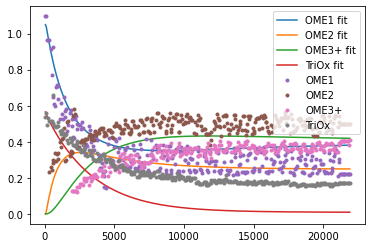

In [181]:
rc=[
    [f[0][0],f[0][1]],
]+[[f[0][2],f[0][3]] for  _ in  range(n_omes-1)]
rc=np.array(rc)


r=simulate_reaction_set(rm, rc, ic, ts)
triox_fit=r["y"][0]
ome1_fit=r["y"][2]
ome2_fit=r["y"][3]
ome3p_fit=r["y"][4:].sum(0)

plt.plot(r["t"],ome1_fit,label="OME1 fit")
plt.plot(r["t"],ome2_fit,label="OME2 fit")
plt.plot(r["t"],ome3p_fit,label="OME3+ fit")
plt.plot(r["t"],triox_fit,label="TriOx fit")

plt.plot(ts,n_cs[t_map,0],".",label="OME1")
plt.plot(ts,n_cs[t_map,1],".",label="OME2")
plt.plot(ts,n_cs[t_map,2],".",label="OME3+")
plt.plot(ts,n_cs[t_map,3],".",label="TriOx")
plt.legend()

In [159]:
np.nan_to_num(n_cs[t_map][:,0:(3+1)])

array([[1.09620006, 0.        , 0.        , 0.54002844],
       [1.09620006, 0.        , 0.        , 0.55709166],
       [0.96564393, 0.        , 0.        , 0.49384039],
       ...,
       [0.22319953, 0.50017531, 0.40253105, 0.16901633],
       [0.22319953, 0.50017531, 0.38405529, 0.16901633],
       [0.22319953, 0.50017531, 0.41169115, 0.16901633]])

In [148]:
r["y"][3:].sum(0)

array([0.        , 0.01052339, 0.03035459, 0.05196066, 0.07317466,
       0.12264322, 0.14054848, 0.15755875, 0.17367819, 0.18894703,
       0.20341   , 0.21709955, 0.23007015, 0.24235987, 0.25400534,
       0.27908846, 0.2888238 , 0.29810195, 0.30693214, 0.31532229,
       0.32330881, 0.33091968, 0.33817839, 0.34508996, 0.35169101,
       0.36703874, 0.3726656 , 0.37805929, 0.38322776, 0.38817571,
       0.3929212 , 0.39747106, 0.40184154, 0.4060347 , 0.41007305,
       0.41897557, 0.42251663, 0.42593582, 0.42922605, 0.43239801,
       0.43545418, 0.438403  , 0.44124835, 0.44399501, 0.44664628,
       0.45294495, 0.4552984 , 0.45758061, 0.45979122, 0.46192881,
       0.46399616, 0.46600049, 0.46793863, 0.46981844, 0.47163696,
       0.47569969, 0.47733904, 0.47893327, 0.48047609, 0.48197713,
       0.4834372 , 0.48485578, 0.48623527, 0.48757624, 0.48888022,
       0.49200412, 0.49318199, 0.49432951, 0.49544625, 0.49653184,
       0.49758905, 0.49861702, 0.49961711, 0.50059114, 0.50154